# Decision Trees: Regression

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

## Creating Height Dataset

In [2]:
n = 200

height_pop1_f = np.random.normal(loc=155, scale=4, size=n)
height_pop1_m = np.random.normal(loc=175, scale=5, size=n)
height_pop2_f = np.random.normal(loc=165, scale=15, size=n)
height_pop2_m = np.random.normal(loc=185, scale=12, size=n)

height_f = np.concatenate([height_pop1_f, height_pop2_f])
height_m = np.concatenate([height_pop1_m, height_pop2_m])

df_height = pd.DataFrame(
    {
        'Gender': [1 for i in range(height_f.size)] + [2 for i in range(height_m.size)],
        'Height': np.concatenate((height_f, height_m))
    }
)

df_height.sample(n=8)

Gender      Height
259       1  159.614317
440       2  180.985467
798       2  178.300019
23        1  154.792867
316       1  176.936015
252       1  192.540470
131       1  156.271541
311       1  182.432672

In [3]:
df_height.shape

(800, 2)

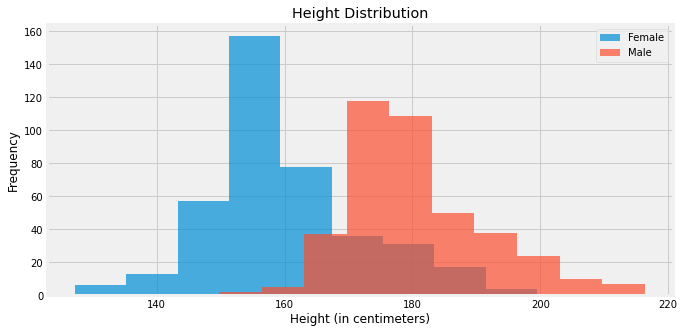

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

df_height[df_height['Gender'] == 1]['Height'].plot(
    label='Female', kind='hist', 
    bins=10, alpha=0.7, ax=ax
)
df_height[df_height['Gender'] == 2]['Height'].plot(
    label='Male', kind='hist', 
    bins=10, alpha=0.7, ax=ax
)

# ax.set_xlim(140, 200)
ax.legend()
ax.set_title('Height Distribution')
ax.set_xlabel('Height (in centimeters)')

fig.show()

In [6]:
df_height.groupby('Gender')[['Height']].agg([np.mean, np.median]).round(1)

Height       
         mean median
Gender              
1       160.1  157.7
2       180.7  178.3

## Splitting Data then applying the Regressor

In [8]:
data = df_height[['Gender']]
target = df_height.Height

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.3,
                                                    random_state=0)

In [11]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()

clf.fit(X_train, y_train)

DecisionTreeRegressor()

- Mean squared error (MSE or L2): Say after the split, we get three samples in one group with targets of 5, 5, and 8. We calculate the mean value of these three numbers (6). Then, we calculate the squared differences between each sample and the calculated mean 1, 1, and 4. We then take the mean of these squared differences, which is 2.
- Mean absolute error (MAE or L1): Say after the split, we get three samples in one group with targets of 5, 5, and 8. We calculate the median value of these three numbers (5). Then, we calculate the absolute differences between each sample and the calculated median 0, 0, and 3. We then take the mean of these absolute differences, which is 1.  

For each possible split at training time, the tree calculates either L1 or L2 for each of the expected sub-groups after the split. A split with the minimum L1 or L2 is then chosen at this step. L1 may be preferred sometimes due to its robustness to outliers. The other important difference to keep in mind is that L1 uses median while L2 uses mean in its calculations.


In [12]:
from sklearn.tree import export_text
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
)

criterions = ['mse', 'mae']

for criterion in criterions:
  reg = DecisionTreeRegressor(criterion=criterion)
  reg.fit(X_train, y_train)
  print(f'\ncriterion={criterion}:\n')
  print(export_text(reg, feature_names=['Gender'], spacing=3, decimals=1))

  y_pred = reg.predict(X_test)

  print('MSE:', round(mean_squared_error(y_test, y_pred), 1))
  print('MAE:', round(mean_absolute_error(y_test, y_pred), 1))


criterion=mse:

|--- Gender <= 1.5
|   |--- value: [160.0]
|--- Gender >  1.5
|   |--- value: [181.0]

MSE: 146.1
MAE: 9.1

criterion=mae:

|--- Gender <= 1.5
|   |--- value: [157.0]
|--- Gender >  1.5
|   |--- value: [178.6]

MSE: 152.4
MAE: 8.9


Of course, we only had one binary feature in our dataset—gender. That's why we had a very shallow tree with a single split (a stub). Actually, in this case, we do not even need to train a decision tree; we could have easily calculated the mean heights for males and females and used them as our expected values right away. The decisions made by such a shallow tree are called biased decisions. If we would have allowed each individual to express themselves using more information, rather than just their gender, then we would have been able to make more accurate predictions for each individual.
Finally, just as in the classification trees, we have the same knobs, such as max_depth, min_samples_split, and min_samples_leaf, to control the growth of a regression tree.

## Setting sample weights

In [13]:
y_train

77     163.926471
409    174.528496
567    175.658584
483    171.043701
109    152.718220
          ...    
763    189.151459
192    154.635270
629    184.319447
559    180.931419
684    176.710069
Name: Height, Length: 560, dtype: float64

In [14]:
for who_gets_more_weight in ['below 150', 'above 150']:
    rgrsr = DecisionTreeRegressor(criterion='mse')
    if who_gets_more_weight == 'below 150':
        sample_weight = y_train.apply(lambda h: 10 if h <= 150 else 1)
    else:
        sample_weight = y_train.apply(lambda h: 10 if h > 150 else 1)
    rgrsr.fit(X_train, y_train, sample_weight=sample_weight)

    print(f'\nEmphasis on {who_gets_more_weight}:\n')
    print(export_text(rgrsr, feature_names=['Gender'], spacing=3, decimals=1))
    
    y_test_pred = rgrsr.predict(X_test)
    
    print('MSE:', round(mean_squared_error(y_test, y_test_pred), 1))
    print('MAE:', round(mean_absolute_error(y_test, y_test_pred), 1))


Emphasis on below 150:

|--- Gender <= 1.5
|   |--- value: [151.5]
|--- Gender >  1.5
|   |--- value: [181.0]

MSE: 185.5
MAE: 10.1

Emphasis on above 150:

|--- Gender <= 1.5
|   |--- value: [162.1]
|--- Gender >  1.5
|   |--- value: [181.0]

MSE: 147.2
MAE: 9.4
